# **NeuroLens: Brain Tumor Classification with EfficientNet and Grad-CAM**
### *- Jonnalagadda Sri Harsha*


Let's be honest — most brain tumor classification projects out there feel kind of... copy-pasted. Load a few MRI scans, slap on a CNN, get 90% accuracy, and call it a day.
But this one? **It's built differently.**

Instead of stopping at just "tumor" vs. "no tumor," this model dives deeper and confidently classifies MRI brain scans into multiple tumor types:
**Glioma, Meningioma, Pituitary Tumor**, and yes — even the clean, **No Tumor cases.**

And that's not all — I didn't want to build a black-box AI that  would make others wonder at and say, **"But... why did it predict that?"** So I have included **Grad-CAM (Gradient-weighted Class Activation Mapping)**, which acts like X-ray specs for our model. Now you can see exactly what parts of the brain scan the model focused on while making its prediction.

# **1. Downloading and Importing Required Libraries**
In this section, we import all the necessary Python libraries used throughout the project. These include modules for:

**Image processing** **(**like *cv2, PIL, and matplotlib* **)**

**Deep learning** **(**like *tensorflow.keras* for model building and training**)**

**Data handling and preprocessing** **(**like *numpy, os, and sklearn* **)**

**Grad-CAM visualization** tools to interpret how our model makes decisions.

Installing and importing these libraries ensures we have all the tools we need for data preparation, model development, training, and interpretability.

In [ ]:
pip install opendatasets

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from IPython.display import Image
import imutils

# **2. Importing the Brain Tumor MRI Dataset from Kaggle**

Here, we use a simple Python package called opendatasets to download a public dataset from Kaggle. The dataset I am using contains MRI scans of human brains classified into multiple categories like **glioma, meningioma, pituitary tumor, and no tumor**.

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jonnalagaddaharsha
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 1.15GB/s]

In [ ]:
os.mkdir("/content/Crop-Brain-MRI/")
os.mkdir("/content/Crop-Brain-MRI/glioma")
os.mkdir("/content/Crop-Brain-MRI/meningioma")
os.mkdir("/content/Crop-Brain-MRI/notumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary")


os.mkdir("/content/Test-Data")
os.mkdir("/content/Test-Data/glioma")
os.mkdir("/content/Test-Data/meningioma")
os.mkdir("/content/Test-Data/notumor")
os.mkdir("/content/Test-Data/pituitary")

In [ ]:
train_dir = "/content/brain-tumor-mri-dataset/Training/"
test_dir = "/content/brain-tumor-mri-dataset/Testing/"

In [ ]:
classes = os.listdir("/content/brain-tumor-mri-dataset/Training/")
classes

['pituitary', 'notumor', 'glioma', 'meningioma']

In [ ]:
filepath_dict  ={}
for c in classes:
  filepath_dict[c] = list(map(lambda x : train_dir + c + '/' + x, os.listdir(train_dir + c)))

filepath_dict

{'pituitary': ['/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0234.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1337.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0132.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0810.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0516.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1434.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0568.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0964.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0197.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0712.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0110.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0459.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0552.jpg',
  '/content/brain-tumor-mri-dataset/Training/pituit

# **3. Understanding and Visualizing the Dataset**
In this step, we explore the structure of the dataset to understand:

The number of classes (*types of tumors*)

How many images are present in each class

What the MRI scans actually look like

We visualize a few images from each class to gain insights into the data and also check for variations in image quality, orientation, and content. This helps build an intuition about what our model will learn and also spot any irregularities in the dataset.

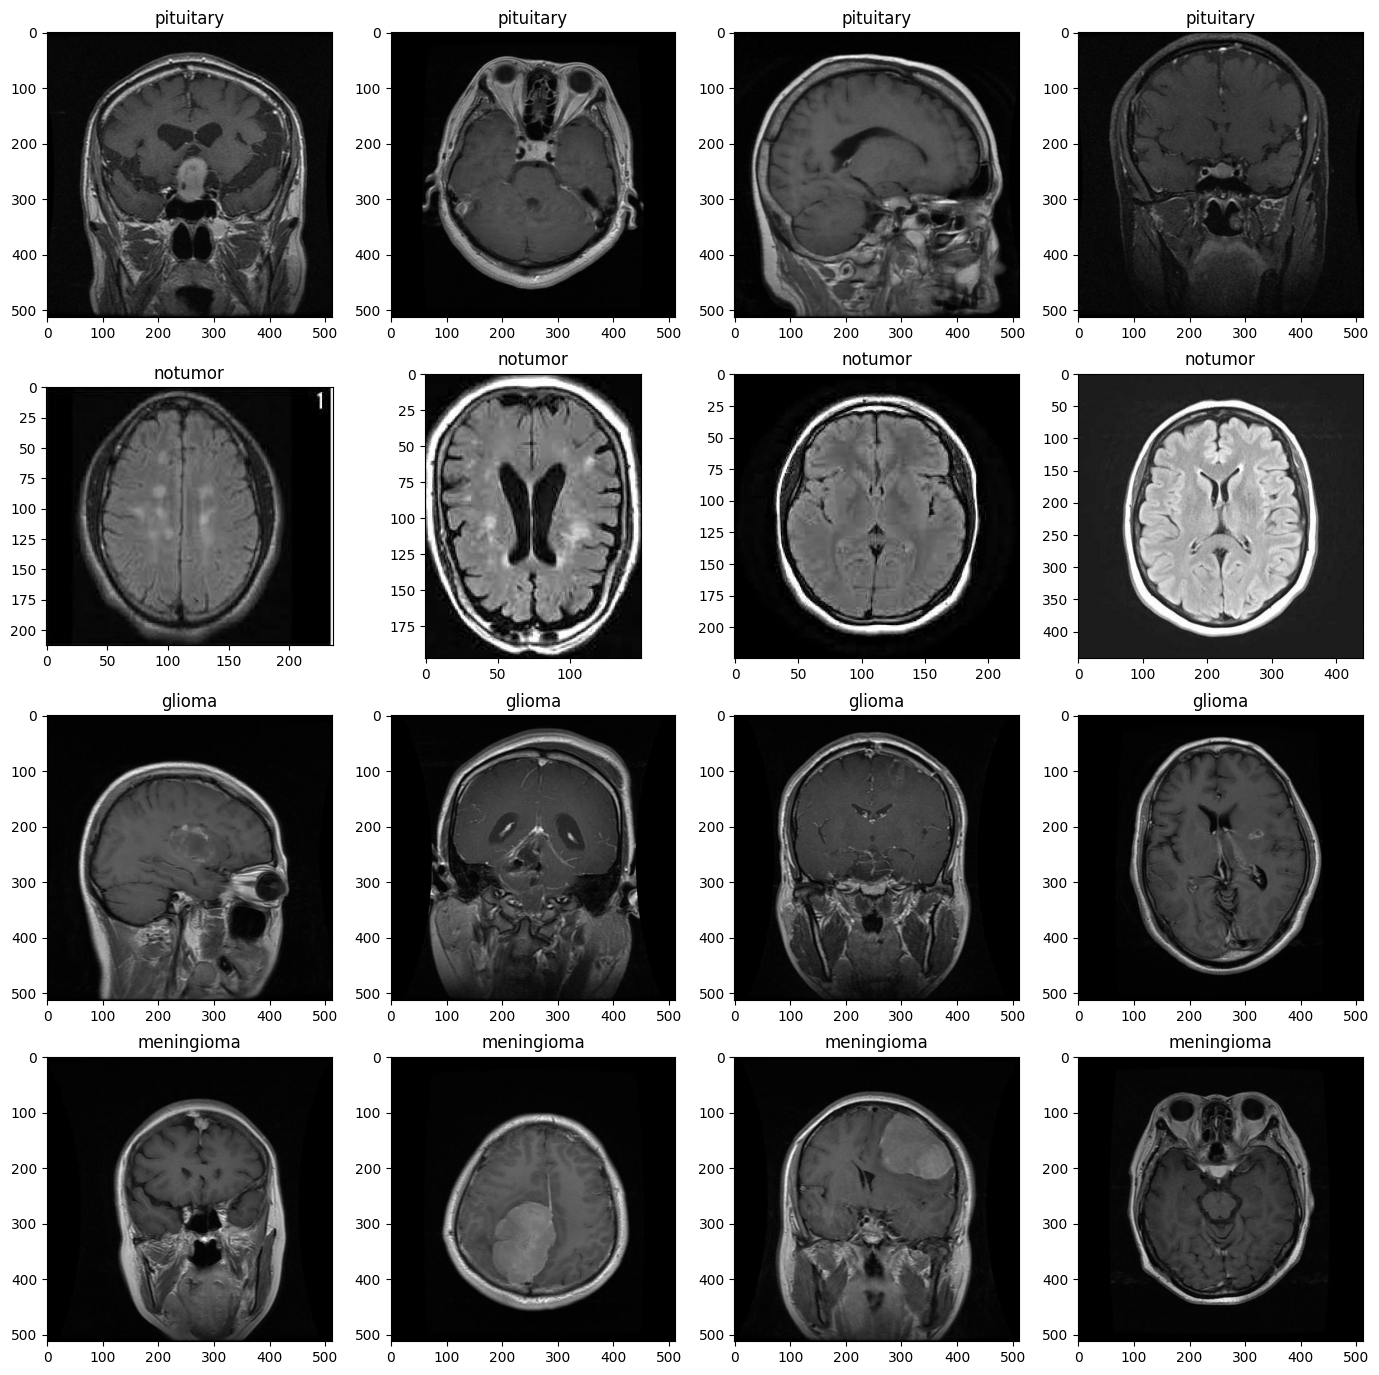

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize = (17, 17))

index = 0

for c in classes:
  random.shuffle(filepath_dict[c])
  path_list = filepath_dict[c][:5]

  for i in range(1, 5):
    index +=1
    plt.subplot(4, 4,index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [ ]:
No_images_per_class = []
Class_name = []
for i in os.listdir("/content/brain-tumor-mri-dataset/Training"):
  train_class = os.listdir(os.path.join("/content/brain-tumor-mri-dataset/Training", i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print(f"Number of images in {i} : {len(train_class)}")

Number of images in pituitary : 1457
Number of images in notumor : 1595
Number of images in glioma : 1321
Number of images in meningioma : 1339


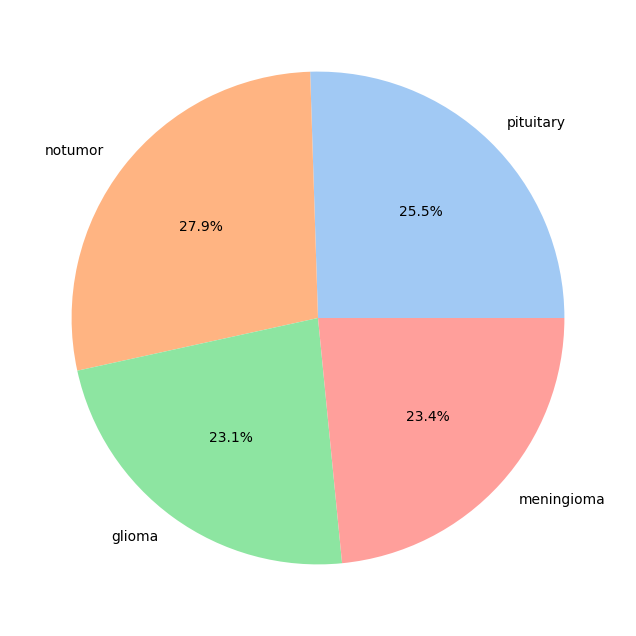

In [ ]:
plt.figure(figsize =(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, labels = Class_name, autopct = "%1.1f%%", colors = colors)
plt.show()

In [ ]:
def crop_image(image, plot=False):

  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
  img_thresh = cv2.threshold(img_blur, 45, 255, cv2.THRESH_BINARY)[1]
  img_thresh = cv2.erode(img_thresh, None, iterations = 2)
  img_thresh = cv2.dilate(img_thresh, None, iterations = 2)

  contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  contours = imutils.grab_contours(contours)

  c = max(contours, key = cv2.contourArea)

  extLeft = tuple(c[c[:, :, 0].argmin()])[0]
  extRight = tuple(c[c[:, :, 0].argmax()])[0]
  extTop = tuple(c[c[:, :, 1].argmin()])[0]
  extBottom = tuple(c[c[:, :, 1].argmax()])[0]

  new_img = image[extTop[1]: extBottom[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(new_img)
    plt.title("Cropped Image")
    plt.show()
  return new_img

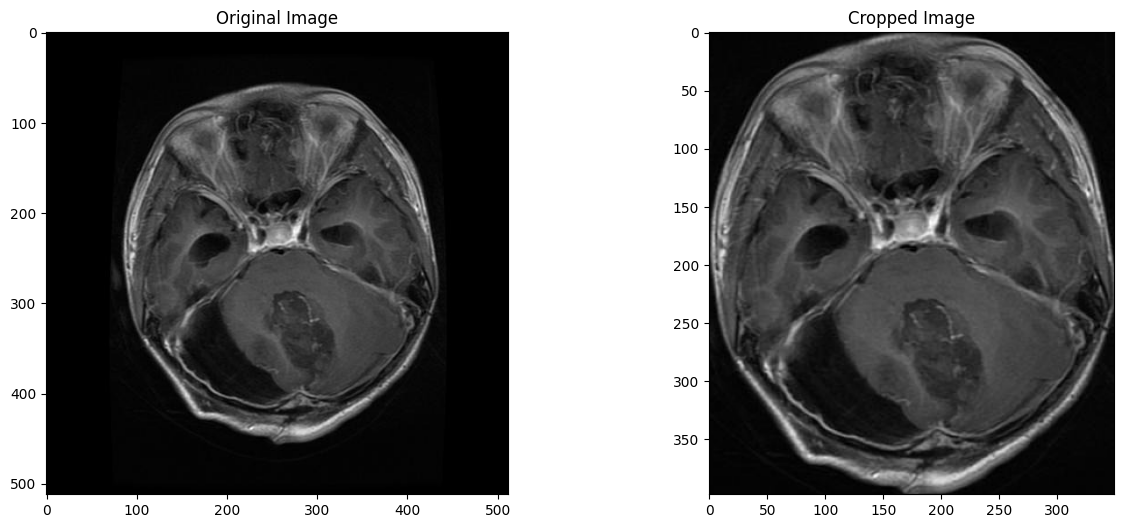

In [ ]:
example_img = cv2.imread("/content/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg")
cropped_imgs = crop_image(example_img, plot=True)

# **4. Cropping and Preprocessing the Images**
Raw MRI images often contain unnecessary black areas or borders that don't contribute to the diagnosis. So here, we preprocess the images by:

**Cropping** out unnecessary black areas

**Resizing** them to a fixed dimension *(suitable for the model input)*

**Normalizing pixel values** to scale the image data between 0 and 1

This step significantly improves model performance by ensuring consistency across all images and focusing only on the relevant brain area.

In [ ]:
glioma = train_dir + 'glioma'
meningioma = train_dir + 'meningioma'
pituitary = train_dir + 'pituitary'
no_tumor = train_dir + 'notumor'
j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/glioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 1321/1321 [00:03<00:00, 383.64it/s]


In [ ]:
j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/meningioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/pituitary/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/notumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 1595/1595 [00:03<00:00, 477.07it/s]


In [ ]:
len(os.listdir(glioma))

1321

In [ ]:
test_glioma = test_dir + 'glioma'
test_meningioma = test_dir + 'meningioma'
test_pituitary = test_dir + 'pituitary'
test_no_tumor = test_dir + 'notumor'
j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/glioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 300/300 [00:00<00:00, 385.20it/s]


In [ ]:
j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/meningioma/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/pituitary/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor , i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/notumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 405/405 [00:01<00:00, 284.95it/s]


# **5. Splitting the Data into Training and Testing Sets**
To evaluate the performance of our model properly, we split the dataset into two parts:

**Training Set:** Used to train the model

**Testing Set:** Used to check how well the model generalizes to unseen data

We use a method like train_test_split to divide the data randomly while maintaining the proportion of each class. This ensures our model doesn't overfit and can be reliably evaluated.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array


datagen = ImageDataGenerator(rotation_range = 10,
                             height_shift_range = 0.2,
                             horizontal_flip = True,
                             validation_split = 0.2)

train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                            target_size = (240, 240),
                            batch_size = 32,
                            class_mode = 'categorical', subset = 'training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                            target_size = (240, 240),
                            batch_size = 32,
                            class_mode = 'categorical', subset = 'validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                            target_size = (240, 240),
                            class_mode = 'categorical', shuffle = False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
test_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

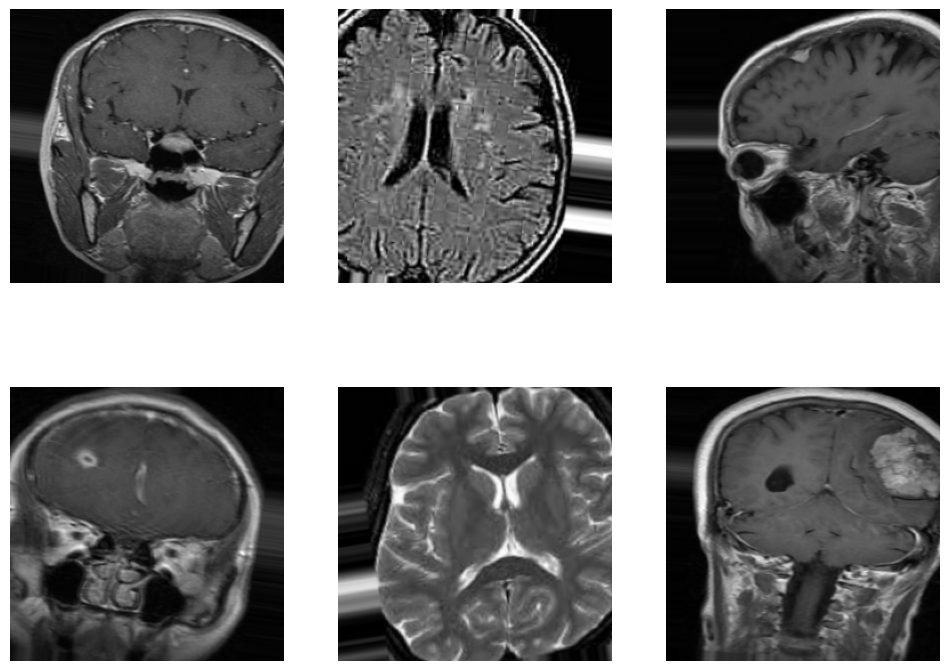

In [ ]:
sample_x, sample_y = next(train_data)

plt.figure(figsize = (12, 9))

for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)

plt.show()

# **6. Defining the Neural Network Architecture using EfficientNetB1**
I am using **EfficientNetB1**, a pre-trained Convolutional Neural Network, as base model. EfficientNet models are known for their *excellent accuracy and computational efficiency.*

* I have removed the original top layers of EfficientNet
* Added some dense layers to adapt it to our classification task
* Compiled the model using suitable ***categorical_crossentropyloss*** function and ***Adam*** optimizer.

This approach leverages transfer learning—reusing a model trained on large datasets (like ImageNet) and fine-tuning it for our specific medical imaging problem.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


effenet  = EfficientNetB1(weights = 'imagenet', include_top = False, input_shape = (240, 240, 3))

model = effenet.output
model = GlobalMaxPooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs=effenet.input, outputs = model)
model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
checkpoint = ModelCheckpoint('model.keras', monitor = 'val_accuracy',
                save_best_only = True,
                mode = 'auto',
                verbose = 1)
earlystop = EarlyStopping(monitor = 'val_accuracy',
              patience = 5,
              mode = 'auto', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                  factor = 0.3,
                  patience = 2,
                  min_delta = 0.001,
                  mode = 'auto', verbose = 1)

# **7. Training the Model and Evaluating Its Performance**
In this step, I have trained the model on the MRI images and tracked its performance using metrics like accuracy and loss.

I have also:

**Plotted training vs validation accuracy and loss** to visually inspect for overfitting or underfitting

Generated a **confusion matrix** to analyze class-wise prediction performance


This thorough evaluation helps us understand how well the model is learning to distinguish between different types of brain tumors.

In [ ]:
%%time
history = model.fit(train_data, epochs = 30, validation_data = valid_data,
                    verbose = 1, callbacks = [checkpoint, earlystop, reduce_lr])

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.4927 - loss: 3.9189

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.77388, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.4938 - loss: 3.9081 - val_accuracy: 0.7739 - val_loss: 0.9604 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8402 - loss: 0.8802
Epoch 2: val_accuracy did not improve from 0.77388
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 569ms/step - accuracy: 0.8403 - loss: 0.8793 - val_accuracy: 0.7502 - val_loss: 1.2630 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9071 - loss: 0.4556
Epoch 3: val_accuracy improved from 0.77388 to 0.82472, saving model to model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 571ms/step - accuracy: 0.9071 - loss: 0.4555 - val_accuracy: 0.8247 - val_loss: 0.8414 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9174 - loss: 0.3201
Epoch 4: val_accuracy improved from 0.82472 to 0.92287, saving model to model

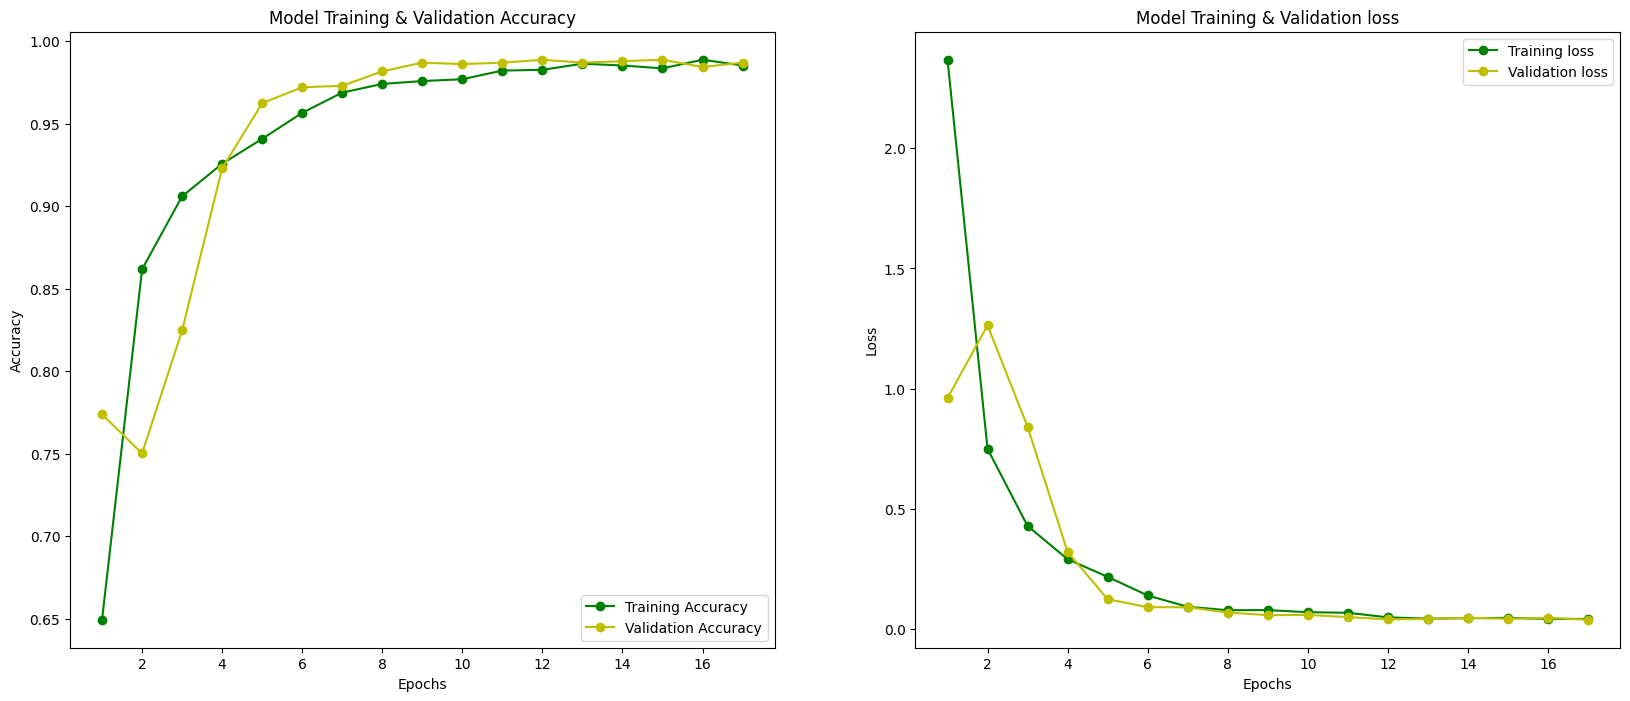

In [ ]:
fig, ax = plt.subplots(1 , 2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'y-o', label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training loss')
ax[1].plot(epochs, val_loss, 'y-o', label = 'Validation loss')
ax[1].set_title('Model Training & Validation loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
model.evaluate(test_data)

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 605ms/step - accuracy: 0.9863 - loss: 0.0602


[0.040871262550354004, 0.9900839328765869]

In [ ]:
y_test = test_data.classes
y_test_hat = np.argmax(model.predict(test_data), axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step


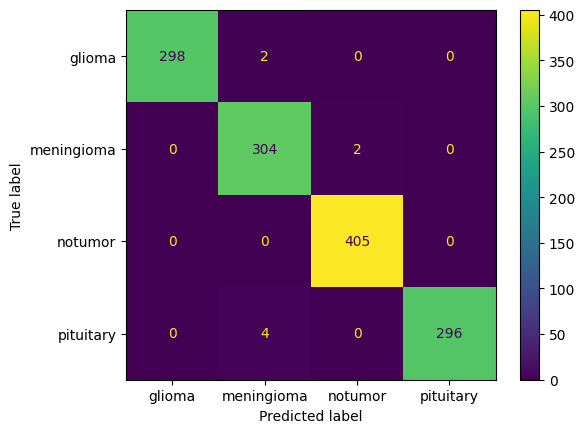

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report
conf_mat = confusion_matrix(y_test, y_test_hat)
conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])
conf_mat_disp.plot()
plt.show()

In [ ]:
#Predicting on test images
import PIL

CLASS_DICT = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
images = []
prediction = []
original = []

for i in os.listdir('/content/Test-Data'):
  for item in os.listdir(os.path.join('/content/Test-Data', i)):
    img = PIL.Image.open(os.path.join('/content/Test-Data', i, item))
    images.append(img)
    img = np.expand_dims(img, axis = 0)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(CLASS_DICT[predict])
    original.append(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

Accuracy on test images : 0.9931350114416476


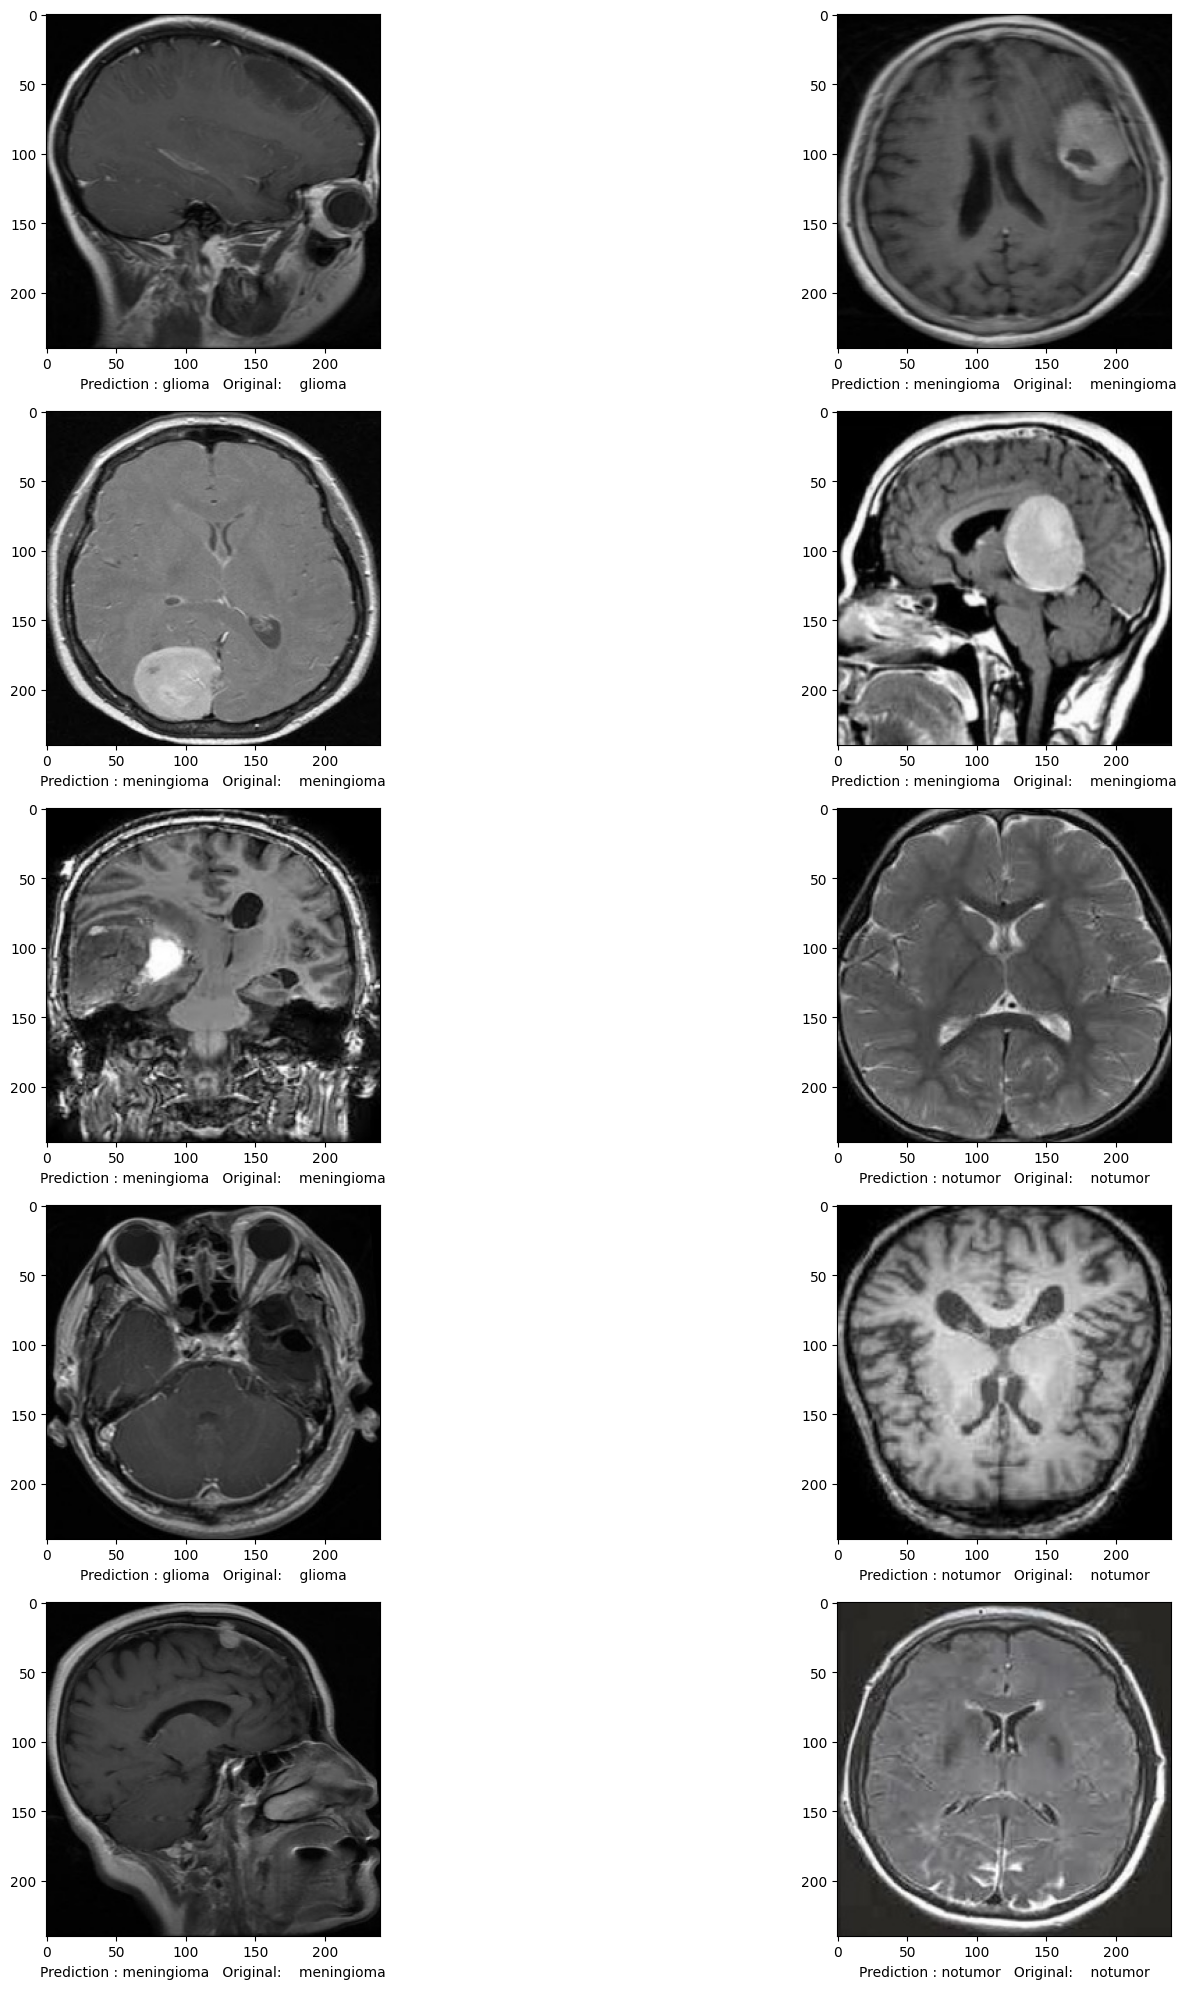

In [ ]:
score = accuracy_score(original, prediction)
print(f"Accuracy on test images : {score}")
fig = plt.figure(figsize = (20, 20))

for i in range(10):
  j = random.randint(0, len(images))
  fig.add_subplot(5, 2, i+1)
  plt.xlabel("Prediction : " + prediction[j] + "   Original:    " + original[j])
  plt.imshow(images[j])
fig.tight_layout()
plt.show()

# **8. Interpreting Model Decisions with Grad-CAM**
Deep learning models are often criticized for being "black boxes." To address this, I have used ***Grad-CAM (Gradient-weighted Class Activation Mapping)*** to visualize ***which parts of the image influenced the model's decision.***

Grad-CAM overlays a heatmap on the original image, highlighting regions the model considered important. This step is crucial in medical AI applications to ensure the model is not making predictions based on irrelevant features and is focusing on actual tumor regions.

In [ ]:
import tensorflow as tf
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [ ]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    # Sanity Check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    prediction_idx = np.argmax(prediction)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


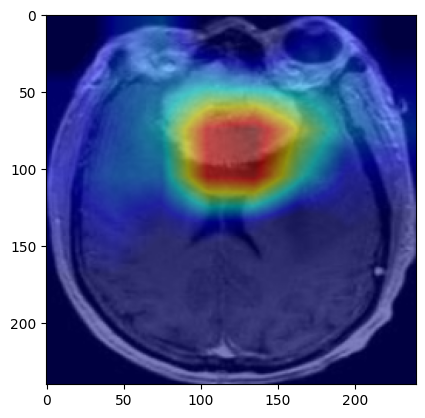

In [ ]:
# Seeing the implementation of VizGradCAM on any of the scans -
test_img = cv2.imread("/content/Test-Data/meningioma/10.jpg")
VizGradCAM(model, img_to_array(test_img), plot_results=True)